<a href="https://colab.research.google.com/github/fedorgrab/EAI6000/blob/master/assignment_3_street_view_house_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [1]:
!pip install openml # Uncomment to run in Google Colab

In [2]:
import time
from contextlib import suppress
import openml as oml
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import warnings
with suppress(Exception):
  %tensorflow_version 2.x
  
import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore')
%matplotlib inline

TensorFlow 2.x selected.


Constants:

In [0]:
BASE_DIR = "/content/drive/My Drive/homework/"

Settings:

In [4]:
# Switches:
GET_SAVED_DATA_FROM_DRIVE = True
DARK_THEME = True

# Other Settings:
drive.mount("/content/drive")
matplotlib_theme = "dark_background" if DARK_THEME else "seaborn"
plt.style.use(matplotlib_theme)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
if not GET_SAVED_DATA_FROM_DRIVE:
    SVHN = oml.datasets.get_dataset(41081)

    X, y, cats, attrs = SVHN.get_data(
        dataset_format="array", 
        target=SVHN.default_target_attribute
    )

In [0]:
if not GET_SAVED_DATA_FROM_DRIVE:
    with open(f"{BASE_DIR}SVHN.pkl", "wb") as f:
        pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
        pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
if GET_SAVED_DATA_FROM_DRIVE:
    with open(f"{BASE_DIR}SVHN.pkl", "rb") as f:
        X = pickle.load(f)
        y = pickle.load(f)
        cats = pickle.load(f)
        attrs = pickle.load(f)

In [0]:
class_labels = { i: i + 1 if i < 9 else 0  for i in range(10)}

### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [9]:
X.shape

(99289, 3072)

1. Array X has 99289 images. 
2. Images are presented in one dimensional arrays, which have to be reshaped to 3 32x32 arrays.
3. That means that tensor has shape (99289, 3, 32, 32)

### You can use the following function to plot the first 10 images to get a sense of the data.

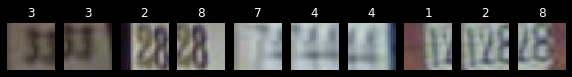

In [10]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32) / 255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n, ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n, ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]

plot_images(X[10:20], y[10:20])

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

To convert images to grayscale format I decided to choose Luminance method: weighted average of rgb channels with weights: 0.3R + 0.59G + 0.11B.



In [0]:
X_g = X.reshape(99289, 32, 32, 3)

r, g, b = X_g[:, :, :, 0], X_g[:,:,:, 1], X_g[:,:,:,2]
X_g = ((0.3 * r + 0.59 * g + 0.11 * b) / 255).reshape(99289, 1024)

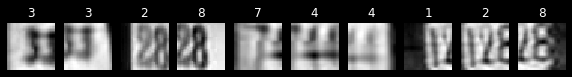

In [12]:
plot_images(X_g[10:20], y[10:20], grayscale=True)

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

In [0]:
import seaborn as sns
import pandas as pd

def dist_plot(values):
    val_counts = pd.Series(values).value_counts()
    plt.bar(val_counts.index, val_counts.values)
    plt.title("Number values distribution plot")
    plt.xlabel("Number")
    plt.ylabel("Amount of values")

I hope python would include smth like this decorator in builtins, because I really often use my workpiece:

In [0]:
import time
import functools

def time_it(func):

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        print(f"---- {np.round(time.time() - start_time, 5)} seconds ----")
        return result

    return wrapper

In [0]:
from sklearn.model_selection import cross_validate

@time_it
def evaluate_learners(classifiers, X, y, number_of_folds=3):
    cross_validations = [
        cross_validate(model, X, y, return_train_score=True, cv=number_of_folds) 
        for model in classifiers
    ]

    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )


In [0]:
from sklearn.model_selection import train_test_split

Xs, _, ys, _ = train_test_split(X_g, y, stratify=y, train_size=0.01)

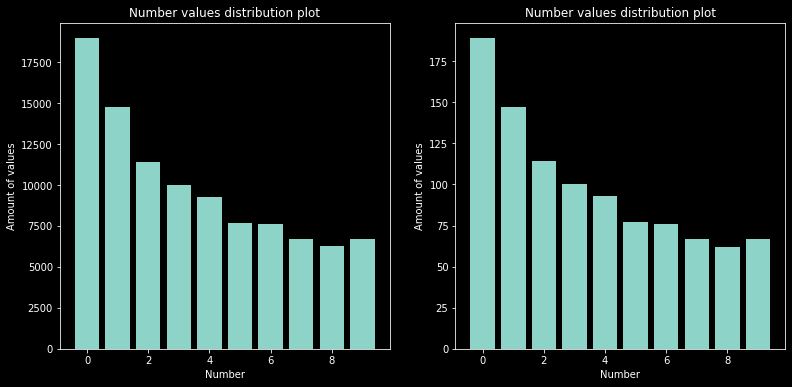

In [17]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1) 
dist_plot(y)
plt.subplot(1,2,2)
dist_plot(ys)

The figures pretty much the same, rhus splitting is good

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

classifiers = [LogisticRegression(), KNeighborsClassifier(), LinearSVC()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

---- 40.75087 seconds ----


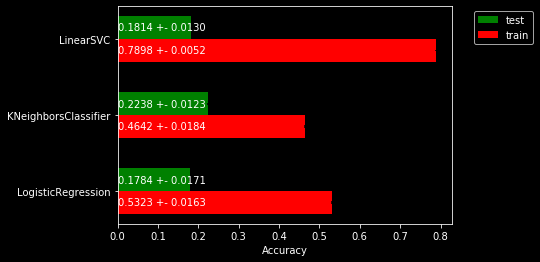

In [19]:
def plot_test_train_scores(train_scores, test_scores):
    fig, ax = plt.subplots()
    width=0.3

    ax.barh(
        np.arange(len(train_scores)), 
        np.mean(test_scores, axis=1),
        width,
        yerr=np.std(test_scores, axis=1), 
        color='green', 
        label='test'
    )
    ax.barh(
        np.arange(len(train_scores))-width, 
        np.mean(train_scores, axis=1), 
        width,
        yerr= np.std(train_scores, axis=1), 
        color='red', 
        label='train'
    )

    for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
        ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
        ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
        
    ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
    ax.set_xlabel('Accuracy')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)


plot_test_train_scores(train_scores, test_scores)

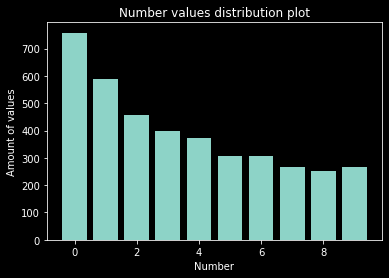

In [20]:
Xs, _, ys, _ = train_test_split(X_g, y, stratify=y, train_size=0.04)

dist_plot(ys)

In [21]:
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

---- 319.19349 seconds ----


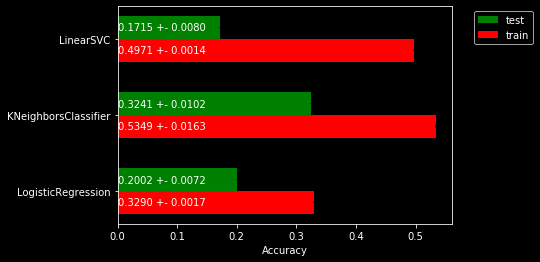

In [22]:
plot_test_train_scores(train_scores, test_scores)

Models are overfitted. I wanted better results. Increasing of sample size caused better result.

When sample size was bigger it took more time to evaluate modls. It was expected because more data you have more time machine needs to process it.

To increase accuracy we need to amend hyperparameters and include more data or use deep learning.

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10)
])

In [0]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_g, y, train_size=0.8)
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X, y, train_size=0.8)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 264,970
Trainable params: 264,970
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train, y_train, epochs=20)

Train on 79431 samples
Epoch 1/20
79431/79431 [==============================] - 16s 199us/sample - loss: 2.0315 - accuracy: 0.2649
Epoch 2/20
79431/79431 [==============================] - 19s 241us/sample - loss: 1.6303 - accuracy: 0.4418
Epoch 3/20
79431/79431 [==============================] - 18s 230us/sample - loss: 1.4917 - accuracy: 0.5061
Epoch 4/20
79431/79431 [==============================] - 13s 170us/sample - loss: 1.4400 - accuracy: 0.5282
Epoch 5/20
79431/79431 [==============================] - 15s 193us/sample - loss: 1.4058 - accuracy: 0.5422
Epoch 6/20
79431/79431 [==============================] - 15s 190us/sample - loss: 1.3838 - accuracy: 0.5511
Epoch 7/20
79431/79431 [==============================] - 16s 195us/sample - loss: 1.3595 - accuracy: 0.5605
Epoch 8/20
79431/79431 [==============================] - 15s 192us/sample - loss: 1.3355 - accuracy: 0.5679
Epoch 9/20
79431/79431 [==============================] - 16s 198us/sample - loss: 1.3161 - accuracy: 0.5

In [0]:
probability_model = tf.keras.Sequential(
    [model, tf.keras.layers.Softmax()]
)
predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)

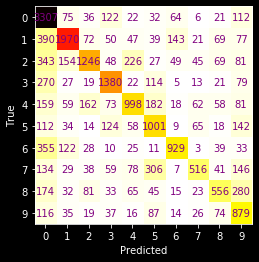

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(y_test, predictions)

def plot_conf_matrix(cm, labels, scale=None):
    fig, ax = plt.subplots()
    cm_scaled = None
    if scale:
        cm_scaled = cm.copy()
        cm_scaled[cm_scaled < cm_scaled.max() / 3] = cm_scaled[cm_scaled < cm_scaled.max() / 3] * scale
        
    if cm_scaled is None:
        im = ax.imshow(cm, cmap=plt.cm.hot_r)

    else:
        im = ax.imshow(cm_scaled)
    
    ax.grid(False)
    ax.set_xticks(list(class_labels.values()))
    ax.set_yticks(list(class_labels.values()))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    for i in range(100):
        if  cm[i%10, int(i/10)]:
            ax.text(
                int(i/10), i%10, cm[i%10,int(i/10)],
                 ha="center", va="center", color="purple"
            )

plot_conf_matrix(cm, list(class_labels.values()))

In [0]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = "blue"
  else:
    color = "red"

  plt.xlabel("{} {:2.0f}% ({})".format(
    class_labels[predicted_label],
    100*np.max(predictions_array),
    class_labels[true_label]
    ), color=color)

def plot_value_array(predictions_array, true_label):
  plt.grid(False)
  plt.xticks(np.arange(10), list(range(10)), rotation=90)
  plt.yticks([])
  ax = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  ax[predicted_label].set_color("red")
  ax[true_label].set_color("blue")

In [0]:
missclassified_query = y_test != predictions

missclassified_images = X_test[missclassified_query]
missclassified_actual_labels = y_test[missclassified_query]
missclassified_probabilities = prediction_probabilities[missclassified_query]

In [32]:
missclassified_images.shape

(7076, 1024)

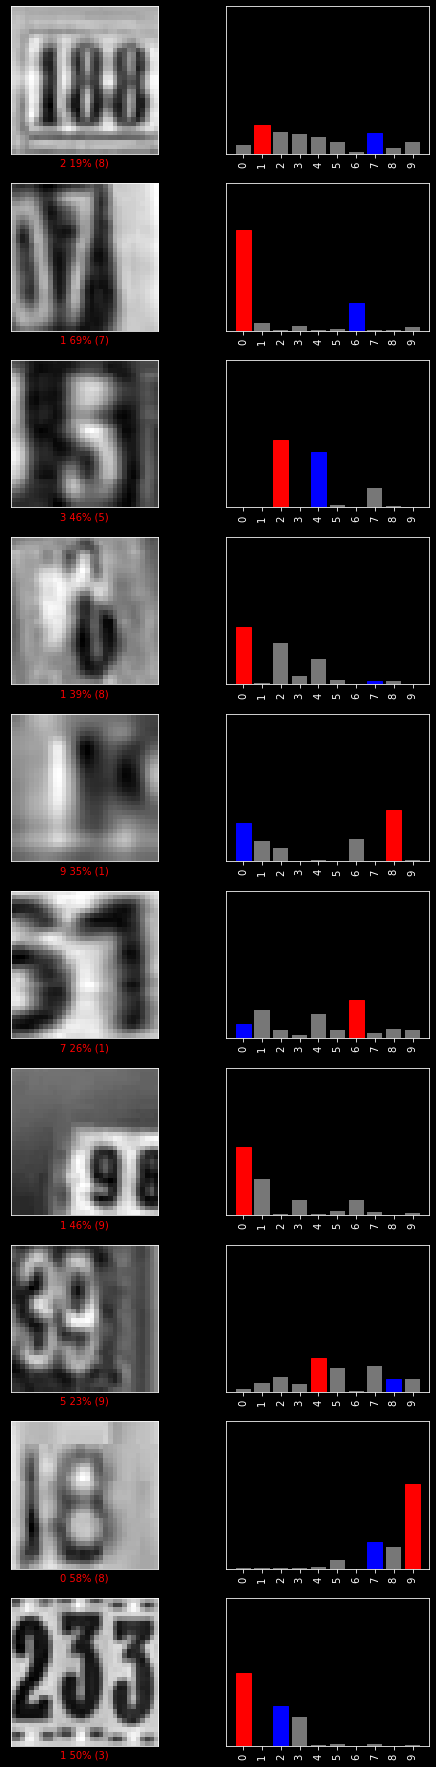

In [33]:
plt.figure(figsize=(8, 32))

for i in range(10):
    plt.subplot(10, 2, 2 * i + 1)
    plot_image(
      missclassified_probabilities[i], 
      missclassified_actual_labels[i],
      missclassified_images[i].reshape(32,32)
    )
    plt.subplot(10, 2, 2 * i + 2)
    plot_value_array(
      missclassified_probabilities[i], 
      missclassified_actual_labels[i]
    )

plt.show()

Unfortunately, I got only 55% of accuracy on training data, so test data would show even less.

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 

I decided to raise accuracy by image processing. So my point is that if I changed the image contrast it would be easier for model to classify the digit. Let's see how is it going to work.

In [34]:
X_c = X_g.reshape(101671936)
X_c.mean()

0.44753543

In [0]:
X_c[X_c > 0.5 ] = 1.0
X_c[X_c < 0.37] = 0.0
X_c = X_c.reshape(99289, 1024)

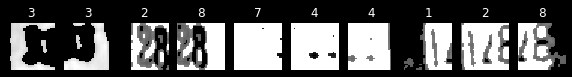

In [36]:
plot_images(X_c[10:20], y[10:20], grayscale=True)

In [0]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y, train_size=0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dense(10)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [39]:
model.fit(X_train_c, y_train_c, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 9s 119us/sample - loss: 1.6939 - accuracy: 0.4346
Epoch 2/10
79431/79431 [==============================] - 9s 117us/sample - loss: 1.2853 - accuracy: 0.5827
Epoch 3/10
79431/79431 [==============================] - 9s 117us/sample - loss: 1.1524 - accuracy: 0.6263
Epoch 4/10
79431/79431 [==============================] - 9s 117us/sample - loss: 1.0724 - accuracy: 0.6517
Epoch 5/10
79431/79431 [==============================] - 9s 107us/sample - loss: 1.0212 - accuracy: 0.6683
Epoch 6/10
79431/79431 [==============================] - 9s 108us/sample - loss: 0.9803 - accuracy: 0.6799
Epoch 7/10
79431/79431 [==============================] - 8s 107us/sample - loss: 0.9520 - accuracy: 0.6892
Epoch 8/10
79431/79431 [==============================] - 9s 108us/sample - loss: 0.9205 - accuracy: 0.6981
Epoch 9/10
79431/79431 [==============================] - 9s 108us/sample - loss: 0.8912 - accuracy: 0.7071
Epoch

In [40]:
from sklearn.metrics import accuracy_score

predictions_c = model.predict_classes(X_test_c)

accuracy_score(y_test_c, predictions_c)

0.6604894752744486

So that's better than 55% but still not good.

In [0]:
X_c_2 = X_g.reshape(101671936)
X_c_2[X_c_2 >= 0.75 ] = 0.875
X_c_2[(X_c_2 >= 0.50) & (X_c_2 < 0.75)] = 0.625
X_c_2[(X_c_2 >= 0.25) & (X_c_2 < 0.50)] = .375
X_c_2[(X_c_2 < 0.25)] = .125

X_c_2 = X_c_2.reshape(99289, 1024)

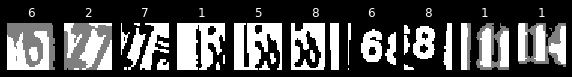

In [42]:
plot_images(X_c_2[1570:1580], y[1570:1580], grayscale=True)

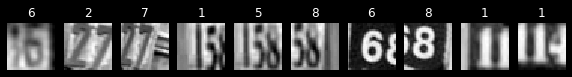

In [43]:
plot_images(X_g[1570:1580], y[1570:1580], grayscale=True)

In [0]:
X_train_c_2, X_test_c_2, y_train_c_2, y_test_c_2 = train_test_split(X_c_2, y, train_size=0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dense(10)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [46]:
model.fit(X_train_c_2, y_train_c_2, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 8s 95us/sample - loss: 2.0077 - accuracy: 0.2968
Epoch 2/10
79431/79431 [==============================] - 7s 89us/sample - loss: 1.5668 - accuracy: 0.4793
Epoch 3/10
79431/79431 [==============================] - 7s 93us/sample - loss: 1.3426 - accuracy: 0.5629
Epoch 4/10
79431/79431 [==============================] - 7s 92us/sample - loss: 1.2144 - accuracy: 0.6086
Epoch 5/10
79431/79431 [==============================] - 7s 90us/sample - loss: 1.1324 - accuracy: 0.6340
Epoch 6/10
79431/79431 [==============================] - 7s 89us/sample - loss: 1.0740 - accuracy: 0.6512
Epoch 7/10
79431/79431 [==============================] - 6s 81us/sample - loss: 1.0213 - accuracy: 0.6695
Epoch 8/10
79431/79431 [==============================] - 7s 83us/sample - loss: 0.9777 - accuracy: 0.6841
Epoch 9/10
79431/79431 [==============================] - 7s 86us/sample - loss: 0.9460 - accuracy: 0.6959
Epoch 10/10
79

In [47]:
predictions_c_2 = model.predict_classes(X_test_c_2)

accuracy_score(y_test_c, predictions_c_2)

0.12110988014905831

Yeah, my idea helped a litte bit (In first case), my model performed better. But I have to little kowledges about neural networks and how they work so that I decided to find in the web what is the best way to recognize images. hopefully, I found CNN.

Afterwards I figured out that what I were doing above is... kinda changing input images before neural network process them to perform better. In other words I applied a humble filter on my dataset to contrast shapes of the digits itselves (OMG, that's what CNN does!).
```
X_c[X_c > 0.5 ] = 1.0 # X_c from X_contrast
X_c[X_c < 0.37] = 0.0
``` 
I decided to raise contrast of black pixels for all the ones which already have more than 0.5 and decrease to 0 for all the ones who have less than 0.37 (the interval between 0.37 and 0.5 I remained untouched just randomly. Moreover these numbers were randomly intuitively generated just a strike out, with the idea that black values should be more black and white values should be white, but I should leave smth untouched just to not to spoil my images).

Of course it was only 1 filter and its logic so so simple and it worked much much worse than it is implemented in CNN's frameworks but I accidentaly ( Or I would say intuitively) decided to do the same approach, what is good, but what is even better is that there is already "invented bike" which performs MUCH better than mine.

Okay, let's try these convolutional layers.

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers

if not GET_SAVED_DATA_FROM_DRIVE:
    convolutional_neural_model = models.Sequential([
        layers.Convolution2D(
            filters=32,
            input_shape=(32, 32, 3), 
            kernel_size=(5, 5), 
            strides=(1, 1),
            activation="relu"
        ),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Convolution2D(
            input_shape=(16, 16, 3),
            filters=64,
            kernel_size=(5, 5),
            activation="relu"
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(len(class_labels), activation="softmax")
    ])
    convolutional_neural_model.compile(
        optimizer="adam",
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )
    convolutional_neural_model.fit(
        X_train_cl.reshape(len(X_train_cl), 32, 32, 3), y_train_cl, epochs=10
    )
else:
    convolutional_neural_model = models.load_model(
        f"{BASE_DIR}/convolutional_neural_model.h5"
    )

Unfortunatelly this model finished with:

loss: 2.3674

accuracy: 0.0938

So after that bad performance I was a little bit upset and decided to [DuckDuckGo different models architectures](https://duckduckgo.com/?q=convnet+example&t=brave&ia=web) (DuckDuckGo is just my search engine, I could alternatively say "to google it", but I don't want to support Google's monopoly over search engines). 

I found [this example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) and decided to implement the same architecture.

In [0]:
X_train = X_train.reshape(len(X_train), 32, 32, 1)
X_test = X_test.reshape(len(X_test), 32, 32, 1)

In [0]:
if not GET_SAVED_DATA_FROM_DRIVE:
    model_2 = models.Sequential([
        layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1)),
        layers.Activation("relu"),
        layers.Conv2D(32, (3, 3)),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding="same"),
        layers.Activation("relu"),
        layers.Conv2D(64, (3, 3)),
        layers.Activation("relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512),
        layers.Activation("relu"),
        layers.Dropout(0.5),
        layers.Dense(len(class_labels)),
        layers.Activation("softmax")
    ])

    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    model_2.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    model_2.fit(X_train, y_train, epochs=10)
else:
    model_2 = models.load_model(f"{BASE_DIR}/model_2.h5")

is 
```
    layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1)),
    layers.Activation("relu"),
```
exact the same as 
```
    layers.Conv2D(32, (3, 3), padding="same", input_shape=(32, 32, 1), activation="relu"),
```
?

Looking at the details that model showed much better performance on image recognition. So. Let's try something else.

I also found a tutorial of one simple CNN [here](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb). Based on that architecture I tried to create my own CNN architecture. 

It is much simplier than the previous one. 

In [0]:
if not GET_SAVED_DATA_FROM_DRIVE:
    model_3 = models.Sequential([
        layers.Convolution2D(
            filters=16, 
            kernel_size=(4, 4), 
            padding="same", 
            input_shape=(32, 32, 1),
            activation="relu"
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Convolution2D(
            filters=32, 
            kernel_size=(4, 4),
            input_shape=(16, 16, 1),
            activation="relu"
        ),
        layers.Convolution2D(
            filters=64,
            kernel_size=(3, 3), 
            padding="same",
            activation="relu"
        ),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(len(class_labels), activation="sigmoid"),
    ])

    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    model_3.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=opt,
        metrics=["accuracy"]
    )
    model_3.fit(
        X_train.reshape(len(X_train), 32, 32, 1), y_train, epochs=10
    )
else:
    model_3 = models.load_model(f"{BASE_DIR}/model_3.h5")

In [58]:
from sklearn.metrics import accuracy_score

predictions_cnn = convolutional_neural_model.predict_classes(
    X_test_cl.reshape(len(X_test_cl), 32,32,3)
)
predictions_cnn_2 = model_2.predict_classes(X_test)
predictions_cnn_3 = model_3.predict_classes(X_test)

accuracy_1 = accuracy_score(y_test, predictions_cnn)
accuracy_2 = accuracy_score(y_test, predictions_cnn_2)
accuracy_3 = accuracy_score(y_test, predictions_cnn_3)

print(
    f"Model 1 score: {np.round(accuracy_1 * 100, 3)}%",
    f"Model 2 score: {np.round(accuracy_2 * 100, 3)}%",
    f"Model 3 score: {np.round(accuracy_3 * 100, 3)}%",
    sep="\n"
)

Model 1 score: 9.185%
Model 2 score: 91.691%
Model 3 score: 92.884%


1. It showed almost the same test result.
2. It had been fitting much faster

In [0]:
convolutional_neural_model.save(f"{BASE_DIR}/convolutional_neural_model.h5")
model_2.save(f"{BASE_DIR}/model_2.h5")
model_3.save(f"{BASE_DIR}/model_3.h5")